# Isotropic Scaling Experiment

## Synopsis

In this experiment, I will be looking at how the isotropic scaling effects the HSIC score for the HSIC and KA algorithms. In theory, because we are trying to find one parameter shared between the two kernel functions, there should be problems when the scale of one distribution is larger than another. It's a drawback of the method and it motivates the need to use two different parameters for the distributions.

## Code

In [1]:
import sys, os
# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import warnings
import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.toy import generate_dependence_data

# Kernel Dependency measure
from models.train_models import get_gamma_init
from models.train_models import get_hsic
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

# Plotting
from visualization.distribution import plot_scorer
from visualization.scaling import plot_scorer_scale

# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use(['fivethirtyeight', 'seaborn-poster'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [6]:
plt.style.available

['seaborn-dark-palette',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-deep',
 'tableau-colorblind10',
 'seaborn-talk',
 'fast',
 'seaborn-ticks',
 'seaborn-white',
 'bmh',
 'fivethirtyeight',
 'seaborn-muted',
 '_classic_test',
 'grayscale',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-paper',
 'seaborn-colorblind',
 'seaborn-notebook',
 'Solarize_Light2']

## Data

No handles with labels found to put in legend.


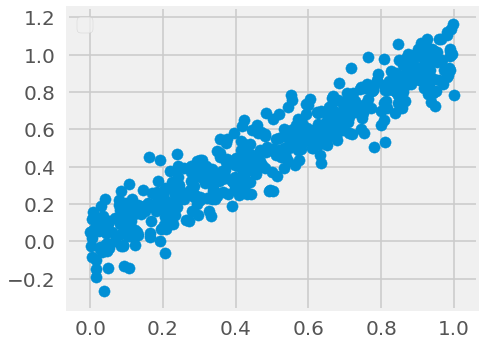

In [39]:
# data params
dataset = 'line'
num_points = 500
seed = 123
noise_x = 0.1
noise_y = 0.1

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y
)

X_scale, Y_scale = X * 10, Y * 10
# plot

fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.scatter(X, Y)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/figures/datasets/'
fig.savefig(f"{save_path}demo_{dataset}.png")

## Prelim. Experiment - Different Scorers and Initializers

In [53]:
# data params
dataset = 'line'
num_points = 500
seed = 123
noise_x = 0.1
noise_y = 0.1

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y
)

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None, None),
    ('scott', None, None),
    ('median', 0.2, None),
    ('median', 0.4, None),
    ('median', None, None),
    ('median', 0.6, None),
    ('median', 0.8, None),
    ('median', None, 0.01),
    ('median', None, 0.1),
    ('median', None, 10),
    ('median', None, 100),
#     ('max', None, None)
]

# results dataframe
results_df = pd.DataFrame()


# run experiment
for iscorer in scorers:
    for imethod in gamma_methods:
        
        # initialize gamma
        gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1], imethod[2])
        
        # get hsic_value
        hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=False)
        
        # append results to dataframe
        gamma_name = get_gamma_name(imethod)
            
        results_df = results_df.append({
            'scorer': iscorer,
            'gamma_method': gamma_name,
            'gamma_init': gamma_init,
            'hsic_value': hsic_value
        }, ignore_index=True)
        
results_df.head()

,gamma_init,gamma_method,hsic_value,scorer
0,5.352818,silverman,0.077120,hsic
1,6.005622,scott,0.081226,hsic
2,35.354261,median_p0.2,0.075767,hsic
3,8.273545,median_p0.4,0.090007,hsic
4,5.726316,median,0.079579,hsic


In [52]:
from typing import Tuple

def get_gamma_name(gamma_method: Tuple[str,str,str])-> str:
    if gamma_method[1] is None and gamma_method[2] is None:
        gamma_name = gamma_method[0]
    elif gamma_method[1] is not None and gamma_method[2] is None:
        gamma_name = f"{gamma_method[0]}_p{gamma_method[1]}"
    elif gamma_method[1] is None and gamma_method[2] is not None:
        gamma_name = f"{gamma_method[0]}_s{gamma_method[2]}"
    elif gamma_method[1] is not None and gamma_method[2] is not None:
        gamma_name = f"{gamma_method[0]}_s{gamma_method[1]}_s{gamma_method[2]}"
    else:
        raise ValueError('Unrecognized Combination...')
    return gamma_name

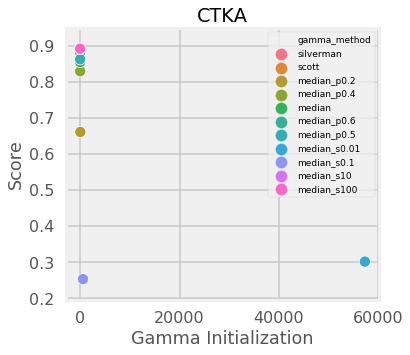

In [54]:
plot_scorer(results_df, 'ctka')

## Experiment: Different Scales Applied to Dataset

In [57]:
# data params
datasets = ['line', 'sine', 'circ', 'rand']
num_points = 1_000
seed = 123
noise_x = 0.1
noise_y = 0.1
beta = 1.0      # keep Y constant (don't scale)


# max params
n_gamma = 50
factor = 1

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None, None),
    ('scott', None, None),
    ('median', 0.2, None),
    ('median', 0.4, None),
    ('median', None, None),
    ('median', 0.6, None),
    ('median', 0.8, None),
    ('median', None, 0.01),
    ('median', None, 0.1),
    ('median', None, 10),
    ('median', None, 100),
#     ('max', None, None)
]

scale_params = np.logspace(-4,4, 50)

# results dataframe
results_df = pd.DataFrame()


# run experiment
with tqdm(gamma_methods) as gamma_bar:
    for imethod in gamma_bar:
        for idataset in datasets:
            for iscorer in scorers:
                for iscale in scale_params:

                    # extract dataset (w. scaling)
                    X, Y = generate_dependence_data(
                        dataset=idataset,
                        num_points=num_points,
                        seed=seed,
                        noise_x=noise_x,
                        noise_y=noise_y,
                        alpha=iscale,
                        beta=beta,
                    )

                    # initialize gamma
                    if imethod[0] == 'max':
                        hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=True, n_gamma=n_gamma, factor=factor)
                    else:
                        gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1], imethod[2])
                        hsic_value = get_hsic(X, Y, iscorer, gamma_init)
                    
                    gamma_name = get_gamma_name(imethod)
                    
                    # append results to dataframe
                    results_df = results_df.append({
                        'dataset': idataset,
                        'scorer': iscorer,
                        'gamma_method': gamma_name,
                        'gamma_init': gamma_init,
                        'hsic_value': hsic_value,
                        'scale': iscale,
                    }, ignore_index=True)
                    
                postfix = dict(
                    Dataset=f"{idataset}",
                    Scorer=f"{iscorer}",
                    Method=f"{gamma_name}"
                )
                gamma_bar.set_postfix(postfix)

results_df.head()

100%|██████████| 11/11 [17:02<00:00, 92.93s/it, Dataset=rand, Scorer=ctka, Method=median_s100] 


,dataset,gamma_init,gamma_method,hsic_value,scale,scorer
0,line,7.063086,silverman,2.675508e-09,0.000100,hsic
1,line,7.063086,silverman,5.674621e-09,0.000146,hsic
2,line,7.063086,silverman,1.203559e-08,0.000212,hsic
3,line,7.063086,silverman,2.552690e-08,0.000309,hsic
4,line,7.063086,silverman,5.414129e-08,0.000450,hsic


In [2]:
results_path = '/home/emmanuel/projects/2019_hsic_align/data/results/scaling/'
results_name = 'scaling_v1.csv'
# results_df.to_csv(results_path + results_name)

In [6]:
results_df = pd.read_csv(results_path + results_name)

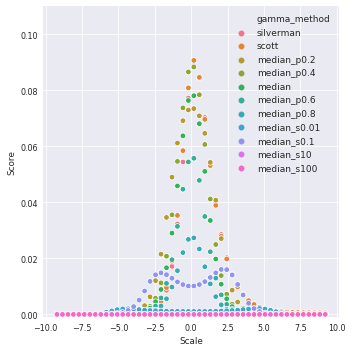

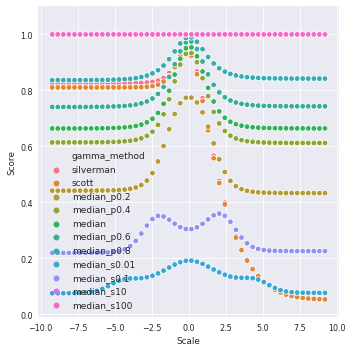

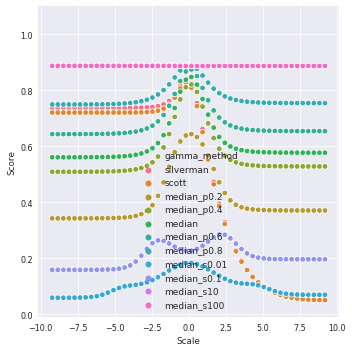

In [13]:
plot_scorer_scale(results_df, 'hsic', 'line', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(results_df, 'tka', 'line', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(results_df, 'ctka', 'line', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')

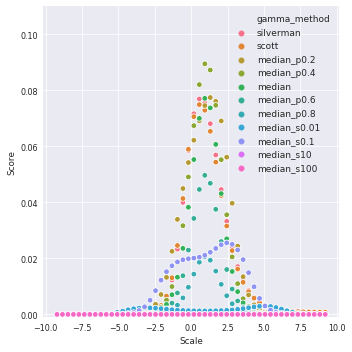

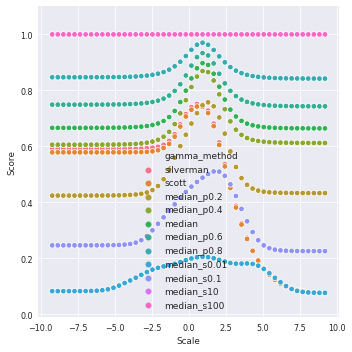

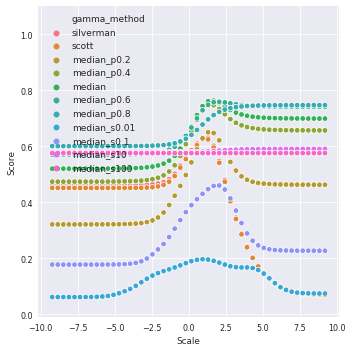

In [14]:
plot_scorer_scale(
    results_df, 'hsic', 'sine', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(
    results_df, 'tka', 'sine', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(
    results_df, 'ctka', 'sine', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')

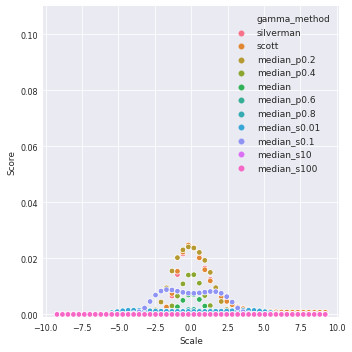

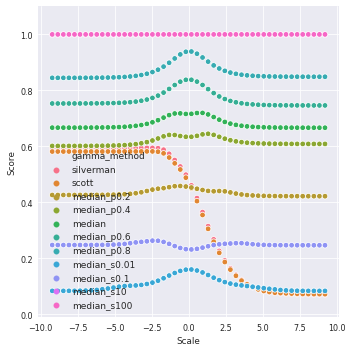

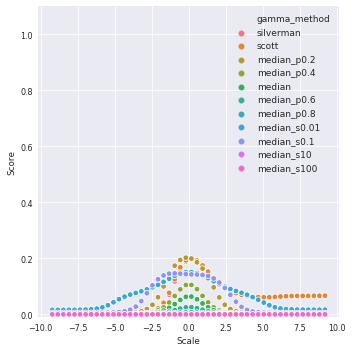

In [15]:
plot_scorer_scale(
    results_df, 'hsic', 'circ', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(
    results_df, 'tka', 'circ', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(
    results_df, 'ctka', 'circ', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')

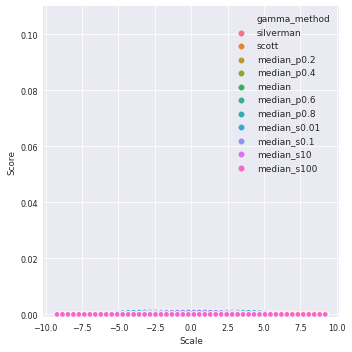

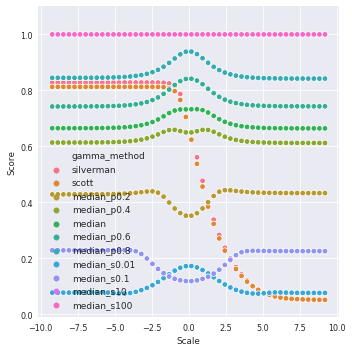

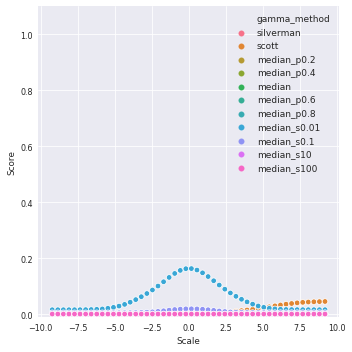

In [16]:
plot_scorer_scale(
    results_df, 'hsic', 'rand', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(
    results_df, 'tka', 'rand', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')
plot_scorer_scale(
    results_df, 'ctka', 'rand', style=['seaborn', 'seaborn-paper'], log_scale=True, save=True, title='')